# Stochastic Analysis

In this section, we will conduct a simple **Monte-Carlo Analysis** to illustrate how parameter uncertainty increases the uncertainty of a model forecast, while available observed potentially reduces the uncertainty.

In [1]:
from math import exp

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

import ifm_contrib as ifm

## Example Model

## Prior Knowledge of Parameters

Before we start modelling, we need a rough idea of the range of values that our model parameters can possibly assume. This might be a result of lab analysis, pump tests, or other means. 

In this case, we use literature values taken from *After Domenico, P.A. and F.W. Schwartz, 1990. Physical and Chemical Hydrogeology, John Wiley & Sons, New York, 824 p.*

The excel table `prior_matprop.xlsx` contains possible ranges of hydraulic conductivities for different materials. These values are:

In [2]:
df_priorinf = pd.read_excel("./data/prior_matprop.xlsx").set_index("material")
df_priorinf

,friendly_name,unit,k_min,k_max
material,,,,
gravel,Gravel,m/sec,3.000000e-04,3.000000e-02
coarse_sand,Coarse Sand,m/sec,9.000000e-07,6.000000e-03
medium_sand,Medium Sand,m/sec,9.000000e-07,5.000000e-04
fine_sand,Fine Sand,m/sec,2.000000e-07,2.000000e-04
silt_loess,Silt / Loess,m/sec,1.000000e-09,2.000000e-05
till,Till,m/sec,1.000000e-12,2.000000e-06
clay,Clay,m/sec,1.000000e-11,4.700000e-09


In order for these ranges to be useful, we need to interprete them as a statistical distribution. One of the simplemost and most commonly applied assumption on parameter likelihood is that it follows a gauss-normal distribution.

In the case of a groundwater model, we assume that many model parameters actually vary by their order of magnitude, especially the hydraulic conducitivity. Consequentially, a **log-normal** distribution is used.

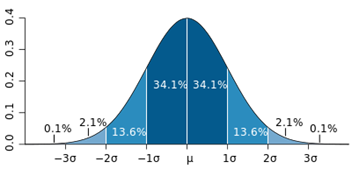

The (log-)normal distribution characterized by its mean and standard deviation values. 

+ For the mean valuve $\mu$, we can simply assume that the lower and upper parameter bounds are symetrically chosen, meaning that the mean values is simply the average of both.

In [3]:
# calculate mean and sigma for a log-normal distribution:
df_priorinf["k_mean"] = 10 ** ((np.log10(df_priorinf.k_max) + np.log10(df_priorinf.k_min)) / 2)

+ For the standard deviation $\sigma$, the situation is less unambiguous. Since the gaussian distribution does not have any actual minimum or maximum boundaries, we instead need to interprete the bundaries provided by the literature as certain confidence intervals. This is somewhat subjective, typical choices are the 95% confidence interval (where the bounds are approximately $\mu \pm 2 \sigma$) or the 99.8 % confidence intervall (where the bounds are approximately $\mu \pm 3 \sigma$. This is somewhat subjective, however we are going to use the latter one in here:

In [4]:
# the mean +/- 3 sigma confidence interval stretches 6 standard deviations in total: 
spread_sigma = 6

# now we can calculate sigma for a log-normal distribution:
df_priorinf["k_sigma"] = 10 ** ((np.log10(df_priorinf.k_max) - np.log10(df_priorinf.k_min)) / spread_sigma)

In [5]:
df_priorinf.loc[["fine_sand", "coarse_sand"]]

,friendly_name,unit,k_min,k_max,k_mean,k_sigma
material,,,,,,
fine_sand,Fine Sand,m/sec,2.000000e-07,0.0002,0.000006,3.162278
coarse_sand,Coarse Sand,m/sec,9.000000e-07,0.0060,0.000073,4.338285


This gives us the likelihood of the different parameter values before calibrating the model (this is called the **prior** uncertainty):

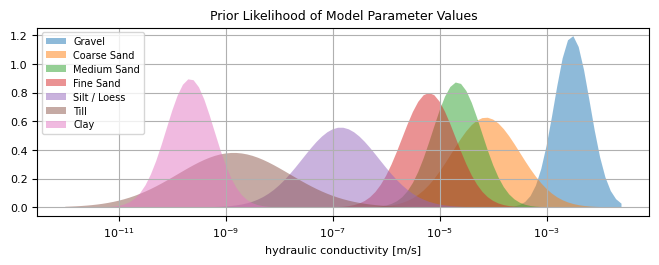

In [6]:
plt.style.use("DHI-wide")
fig, ax1 = plt.subplots(1, figsize=(6.693, 4.136/1.5))

x = (np.arange(np.log10(df_priorinf.k_min.min()), np.log10(df_priorinf.k_max.max()), 0.1))
for i, matprop in df_priorinf.iterrows():
    ax1.fill_between(10**x, 0, stats.norm.pdf(x, np.log10(matprop.k_mean), np.log10(matprop.k_sigma)),
             label=matprop.friendly_name, alpha=0.5)

ax1.set_title("Prior Likelihood of Model Parameter Values")
ax1.legend(loc="upper left")

ax1.set_xscale('log')
ax1.set_xlabel('hydraulic conductivity [m/s]')
ax1.grid()


## Create an Ensemble by creating random samples

Back to our question - we are interested in the flow rate through the levee of our tailings facility.

The model allows us to calculate this value for a given combination of parameter values. Because we now have a possible range of parameter values, we will also need to calculate the range of possible flow rates.

Different methods exists to perform this task. One of the simplemost methods is the Monte-Carlo method, which we are going to apply here.

This methods follows three simple steps:
+ draw a random sample of possible parameter combinations
+ run the model for each of these combinations and calculate the flowrate
+ evaluate the results

### Draw random Samples

We are going to start by drawing 2000 random samples for the prior likelihood (Only the first 10 are shown here)

In [7]:
size=2000
df_samples = pd.DataFrame()

# create 2000 samples for the first parameter
df_samples["k_finesand"] = 10**np.random.normal(np.log10(df_priorinf.loc["fine_sand"].k_mean), 
                                                np.log10(df_priorinf.loc["fine_sand"].k_sigma), 
                                                size)
# create 2000 samples for the second parameter
df_samples["k_coarseand"] = 10**np.random.normal(np.log10(df_priorinf.loc["coarse_sand"].k_mean), 
                                                 np.log10(df_priorinf.loc["coarse_sand"].k_sigma), 
                                                 size)
# show the resulting table
df_samples.head(10)

,k_finesand,k_coarseand
0,0.000027,0.000643
1,0.000004,0.000114
2,0.000054,0.000110
3,0.000002,0.000019
4,0.000014,0.000683
5,0.000005,0.000006
6,0.000004,0.000107
7,0.000012,0.000118
8,0.000012,0.000006
9,0.000005,0.000431


For practical reasons, we often cut away any samples that may have randomly assumed very extreme values. This makes sure that our model runs stable, which may not be the case if we are unlucky.

In [8]:
# cut away any outliers - necessary to ensure the model can handle the input
df_samples = df_samples.loc[(df_priorinf.loc["coarse_sand"].k_min < df_samples.k_coarseand) &
               (df_priorinf.loc["coarse_sand"].k_max > df_samples.k_coarseand)&
               (df_priorinf.loc["fine_sand"].k_min < df_samples.k_finesand) &
               (df_priorinf.loc["fine_sand"].k_max > df_samples.k_finesand) ]       

Now we can visualize the sample set by plotting the values on a scatter plot against both parameter axis. (This is also called the **parameter space**). The density of the points is higher towards the center of the plots, where the points are close to the means of both parameters, and become sparser towards the outside. If looking closely, you may notice a slight asymmetry, which is a result of the standard deviation being different for the two parameters.

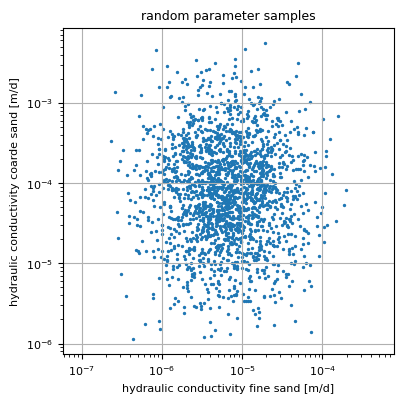

In [9]:
plt.style.use("DHI-square")
fig, ax1 = plt.subplots(1, figsize=(4.136, 4.136))

ax1.scatter(df_samples.k_finesand, df_samples.k_coarseand, s=2)

ax1.set_title("random parameter samples")
ax1.set_xscale('log')
ax1.set_xlabel('hydraulic conductivity fine sand [m/d]')
ax1.set_yscale('log')
ax1.set_ylabel('hydraulic conductivity coarde sand [m/d]')
ax1.axis("equal")
ax1.grid()

## Model Calculation from the Prior Parameter Distribution

Now, lets feed the parameters into the model. First, we load the model, and then run a loop where we iterate over the samples, apply the corresponding parameter values to the model, and then run the model.

For each model run, we record the resulting flow rate.

In [10]:
doc = ifm.loadDocument("./model/femdata/dam_steady_raw.fem")

In [11]:
from ipywidgets import IntProgress
p = IntProgress(max=len(df_samples))
display(p)

IntProgress(value=0, max=1987)

In [ ]:
df_elements = doc.c.mesh.df.elements(par={"COND" : ifm.Enum.P_COND})
flowrates = []
rms =[]
for i, row in df_samples.iterrows():
    p.value+=1
    p.description = f"run {p.value} of {len(df_samples)}"

    df_elements.loc[doc.c.sel.list("Body")]=row.k_coarseand
    df_elements.loc[doc.c.sel.list("Sealing")]=row.k_finesand
    doc.setParamValues(ifm.Enum.P_COND, list(df_elements.COND))
    doc.startSimulator()
    
    # get flowrate from model result
    flowrate = -doc.c.hist.df.FFLUX.iloc[-1]["Air-side border"]
    flowrates.append(flowrate)
    
    # get calibration quality (this will be used later...)
    dh = np.array(doc.c.hist.df.HEAD.iloc[-1][:5]) - np.array(doc.c.hist.df.HEAD.iloc[-1][-5:])
    rms_ = (dh**2).sum()**0.5/len(dh)
    rms.append(rms_)
    
p.description = f"finished."

# add gathered information 
df_samples["flowrate"] = flowrates
df_samples["rms"] = rms

The results of such an analysis are often evaluated by showing the likely outcomes as a histogram. 

In this case, we assume that the levee has a total length of 2000 m, which we apply as a factor to get a useful result:

Text(0.5, 1.0, 'leakage through the levee')

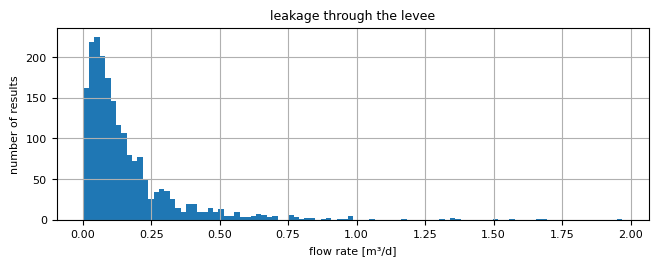

In [15]:
length_of_levee = 2000 # m

fig, ax1 = plt.subplots(1, figsize=(6.693, 4.136/1.5))

(df_samples.flowrate * length_of_levee).hist(ax=ax1, bins=int(size/20))

ax1.set_ylabel("number of results")
ax1.set_xlabel("flow rate [m³/d]")
ax1.set_title("leakage through the levee")

This result already has some value to us. Most of the results are in the lower range of outcomes, meaning that it is likely that the leakage rate is below 500 litres per day (wether this is satisfactory or not depends on the project context).

## Adding measurement information

The previous result assumes that the parameter values is the only information we have. 

However, another piece of information we have not used yet are the measurements of the water level that have been taken in measurement bores in the levee:

Text(0.5, 1.0, 'Available Observation Points')

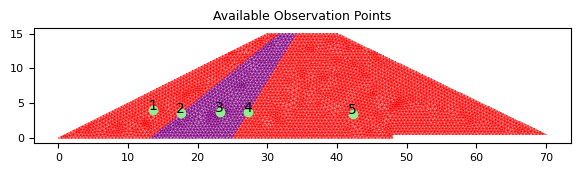

In [23]:
doc.c.plot.patches(par=ifm.Enum.P_COND)
doc.c.plot.obs_markers()
doc.c.plot.obs_labels()
plt.title("Available Observation Points")

In [22]:
doc.c.obs.gdf.obspoints().set_index("label")[["h"]]

,h
label,
1,11.979475
2,11.925297
3,9.801781
4,7.160973
5,5.989028


We can now use this information to evaluate for every model run, how well the observations can be reproduced when using the particular parameter combination. 

A commonly used metric is the RMSE (residual mean square error), defined as

$$ RMSE = \sqrt{\frac{\Sigma^n_{i=1} (h_i - \hat{h}_i)^2}{n}}$$

with

+ $h_i$ the modelled hydraulic head
+ $\hat{h}_i$ the observed hydraulic head

Color-code the parameter space with this metric, we can now see that there is corridor of parameter combinations that obviously fits the results better (purple color) than others (green to red colors):

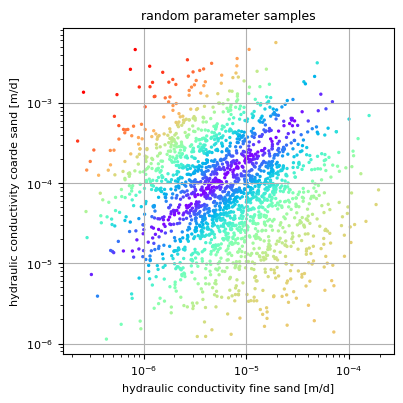

In [24]:
plt.style.use("DHI-square")
fig, ax1 = plt.subplots(1, figsize=(4.136, 4.136))

ax1.set_title("random parameter samples")

ax1.scatter(df_samples.k_finesand, df_samples.k_coarseand, s=2,
           c=df_samples.rms, cmap="rainbow")

ax1.set_xlabel('hydraulic conductivity fine sand [m/d]')
ax1.set_xscale('log')
ax1.set_ylabel('hydraulic conductivity coarde sand [m/d]')
ax1.set_yscale('log')
ax1.grid()

This information is useful as we can use it to further refine our result by rejecting parameter combinations that do not reproduce the measured values:

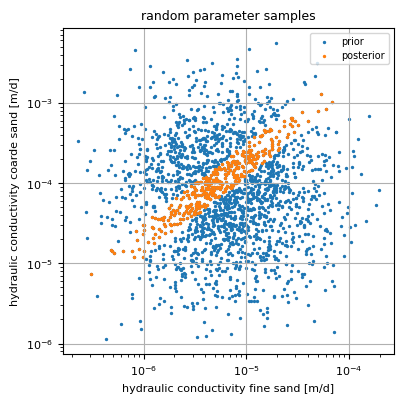

In [30]:
rms_threshold = 0.25

plt.style.use("DHI-square")
fig, ax1 = plt.subplots(1, figsize=(4.136, 4.136))

ax1.set_title("random parameter samples")

ax1.scatter(df_samples.k_finesand, df_samples.k_coarseand, s=2, label="prior")
ax1.scatter(df_samples.loc[df_samples.rms < rms_threshold].k_finesand, 
            df_samples.loc[df_samples.rms < rms_threshold].k_coarseand, s=2, label="posterior")

ax1.set_xlabel('hydraulic conductivity fine sand [m/d]')
ax1.set_xscale('log')
ax1.set_ylabel('hydraulic conductivity coarde sand [m/d]')
ax1.set_yscale('log')
ax1.grid()
ax1.legend()

resulting in filtering out any results related to models that are not compatible with our existing observations of the model.

Text(0.5, 1.0, 'leakage through the levee')

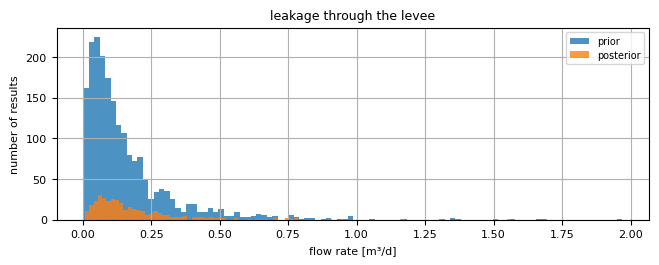

In [33]:
Length_of_levee = 2000 # m

fig, ax1 = plt.subplots(1, figsize=(6.693, 4.136/1.5))

(df_samples.flowrate * length_of_levee).hist(ax=ax1, bins=int(size/20), 
                                             label="prior", alpha=0.8)
(df_samples.loc[df_samples.rms < rms_threshold].flowrate * length_of_levee).hist(ax=ax1, bins=int(size/20), 
                                                                                 label="posterior", alpha=0.8)


ax1.legend()
ax1.set_ylabel("number of results")
ax1.set_xlabel("flow rate [m³/d]")
ax1.set_title("leakage through the levee")

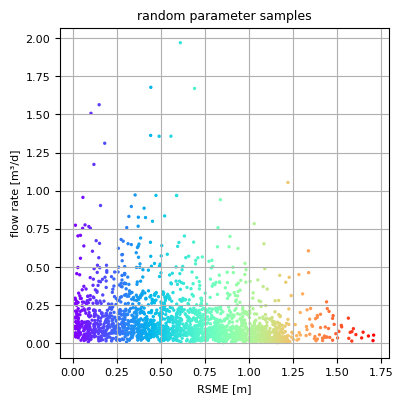

In [38]:
plt.style.use("DHI-square")
fig, ax1 = plt.subplots(1, figsize=(4.136, 4.136))

ax1.set_title("random parameter samples")

ax1.scatter(df_samples.rms, df_samples.flowrate * length_of_levee, s=2,
           c=df_samples.rms, cmap="rainbow")

ax1.set_xlabel('RSME [m]')
#ax1.set_xscale('log')
ax1.set_ylabel('flow rate [m³/d]')
#ax1.set_yscale('log')
ax1.grid()